<h1 style="font-family:verdana;"> <center>🐙Sea Animals Classification using Deep Convolutional Neural Networks and Transfer Learning</center> </h1>
<p><center style="color:#159364; font-family:cursive;">Thanks for visiting my notebook </center></p>

***

<center><img src='https://media1.giphy.com/media/ecrqAkQ0R15yLyButR/200w.webp?cid=ecf05e47sg7i6etxm9s7chixttgu7mnw773hau5kodzkikl3&rid=200w.webp&ct=s' height=150px width=200px></center>

# 👋Thanks for Visting my Notebook
<div class="alert alert-block alert-info" style="font-size:20px; font-family:verdana;">
    📌 Feel free to fork or edit the notebook for your own convenience. If you liked the notebook, consider upvoting. It helps other people discover the notebook as well. Your support inspires me to produce more of these kernel.😊
</div>

# 🔬Overview 
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">Most life forms evolved initially in marine habitats. By volume, oceans provide about 90% of the living space on the planet. The earliest vertebrates appeared in the form of fish, which live exclusively in water. Some of these evolved into amphibians, which spend portions of their lives in water and portions on land. One group of amphibians evolved into reptiles and mammals and a few subsets of each returned to the ocean as sea snakes, sea turtles, seals, manatees, and whales. Plant forms such as kelp and other algae grow in the water and are the basis for some underwater ecosystems. Plankton forms the general foundation of the ocean animal chain, particularly phytoplankton which are key primary producers.<a href='https://en.wikipedia.org/wiki/Marine_life'>Source</a></p>


# ❗Author's Note:
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">Make sure to run the cells from top to bottom with a GPU accelerator. There are some linux commands present in some cells so this is important to take into account. Also, any suggestions, comments and recommendations to improve the notebook will be highly appreciated. Cheers!</p>



# 🏗️Import Necessary Libraries

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('darkgrid')

# 🤙Create helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-03-21 12:39:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-21 12:39:34 (68.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 📥Load and Transform Data

In [3]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [4]:
# Walk through each directory
dataset = "../input/sea-animals-image-dataste"
walk_through_dir(dataset)

There are 23 directories and 0 images in '../input/sea-animals-image-dataste'.
There are 0 directories and 482 images in '../input/sea-animals-image-dataste/Penguin'.
There are 0 directories and 497 images in '../input/sea-animals-image-dataste/Clams'.
There are 0 directories and 499 images in '../input/sea-animals-image-dataste/Lobster'.
There are 0 directories and 500 images in '../input/sea-animals-image-dataste/Otter'.
There are 0 directories and 497 images in '../input/sea-animals-image-dataste/Eel'.
There are 0 directories and 500 images in '../input/sea-animals-image-dataste/Corals'.
There are 0 directories and 531 images in '../input/sea-animals-image-dataste/Puffers'.
There are 0 directories and 483 images in '../input/sea-animals-image-dataste/Squid'.
There are 0 directories and 572 images in '../input/sea-animals-image-dataste/Whale'.
There are 0 directories and 579 images in '../input/sea-animals-image-dataste/Sea Urchins'.
There are 0 directories and 499 images in '../inpu

# 📅Placing data into a Dataframe
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [5]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("../input/sea-animals-image-dataste").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

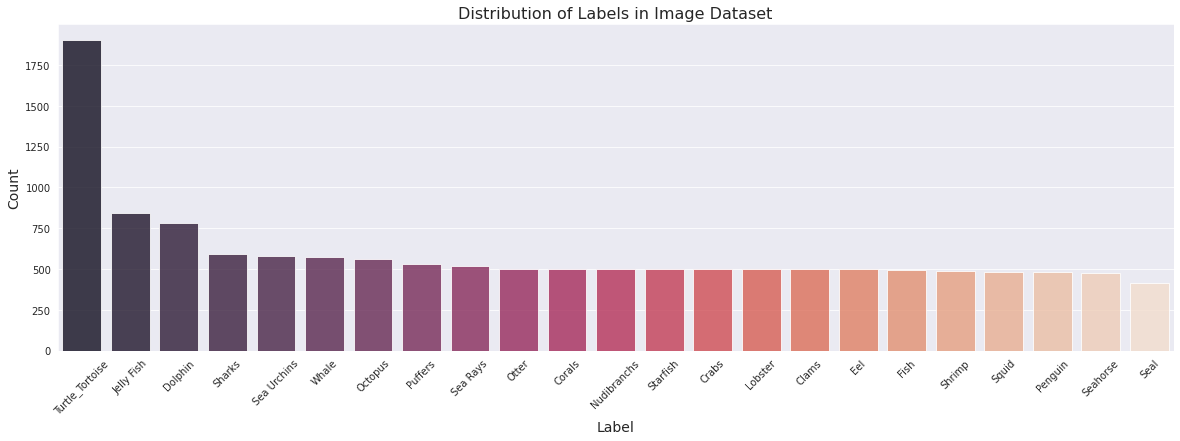

In [7]:
label_counts = image_df['Label'].value_counts()

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45) 
plt.show()


In [8]:
def drop_images(df, **kwargs):
    for key, value in kwargs.items():
        if key in ['Jelly_Fish', 'Sea_Urchins']:
            word = key.split('_')
            key = word[0] + ' ' + word[1]
        indices = list(df[df.Label == key].index.values.astype(int))
        rand_img_sample = random.sample(indices, value)
        df = df.drop(rand_img_sample, axis=0).reset_index(drop=True)
    return df

In [9]:
image_df = drop_images(image_df, Turtle_Tortoise=1400, Jelly_Fish=300, Dolphin=200)

In [10]:
image_df.Label.value_counts().mean()

513.5217391304348

# 🔭Visualizing images from the dataset

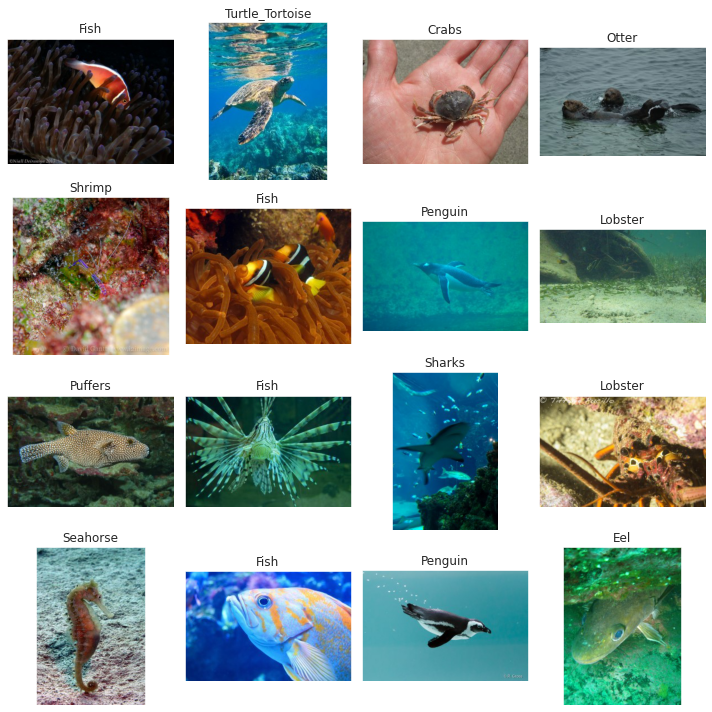

In [11]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# 📝Data Preprocessing
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).</p>

In [14]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [15]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [16]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 7559 validated image filenames belonging to 23 classes.
Found 1889 validated image filenames belonging to 23 classes.
Found 2363 validated image filenames belonging to 23 classes.


In [17]:
class_labels = list(test_images.class_indices.keys())
print(class_labels)

['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


In [18]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
  #layers.experimental.preprocessing.RandomCrop(0.1, 0.1),
  layers.experimental.preprocessing.RandomHeight(0.1),
  layers.experimental.preprocessing.RandomWidth(0.1),
])

# 🤹Training the model
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:</p>

<p style="font-size:20px">
  <strong>Batch size</strong>: 32<br>
  <strong>Epochs</strong>: 100<br>
  <strong>Input Shape</strong>: (224, 224, 3)<br>
  <strong>Output layer</strong>: 23
</p>

In [19]:
# MobileNet HP
width_multiplier = 1.0

In [20]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    alpha=width_multiplier
)

pretrained_model.trainable = False

17620992/17605208 [==============================] - 1s 0us/step


In [21]:
# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoint_mobilenetV3"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [22]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [23]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

# 🚄Training the model

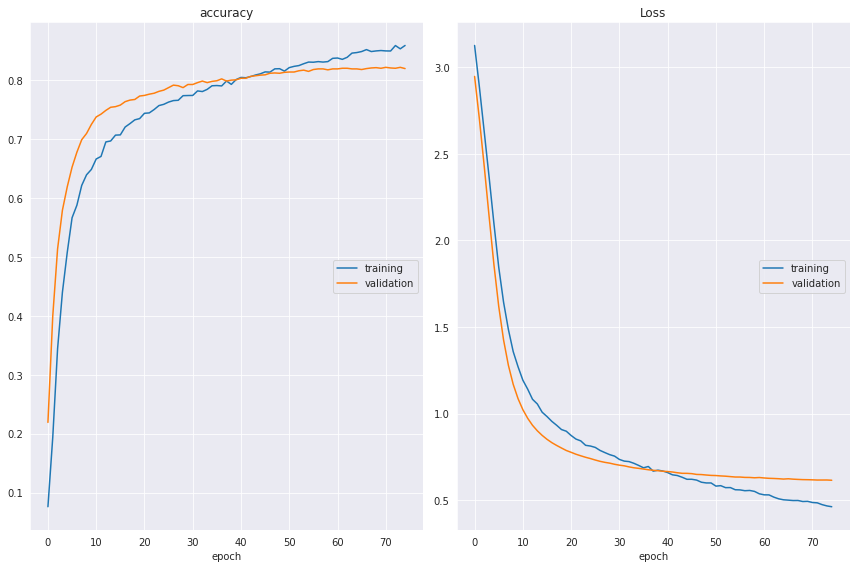

accuracy
	training         	 (min:    0.076, max:    0.859, cur:    0.859)
	validation       	 (min:    0.219, max:    0.822, cur:    0.819)
Loss
	training         	 (min:    0.463, max:    3.126, cur:    0.463)
	validation       	 (min:    0.616, max:    2.947, cur:    0.616)


In [24]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)


outputs = Dense(23, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=75,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "animal_classification"),
        checkpoint_callback,
        PlotLossesKeras(),
    ]
)

In [25]:
model.save('animals_mobilenetV3_1.h5')

***

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
        <p style="padding: 10px;
              color:white;">
            Thanks for viewing my work. If you like it, consider sharing it to others or give feedback to improve the notebook. Have a beautiful day my friend.
        </p>
    </div>

<center><img src='https://media4.giphy.com/media/M9gbBd9nbDrOTu1Mqx/giphy.gif?cid=790b7611704aa2ca4e403287801480a6c753abf45f3e6242&rid=giphy.gif&ct=s' 
     height=30px width=160px /></center>